Let's have a look at filter curves!

In [1]:
# initialization
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import astropy as ast
import astropy.stats
from astropy.io import fits
import scipy as sc
import scipy.signal
import textwrap
import pylab
import itertools
import operator

# this magic command makes plots appear within the notebook
%matplotlib inline

# define figure size parameters to make figures larger than default
figwidth=10
figheight=10

There are 1101 data points


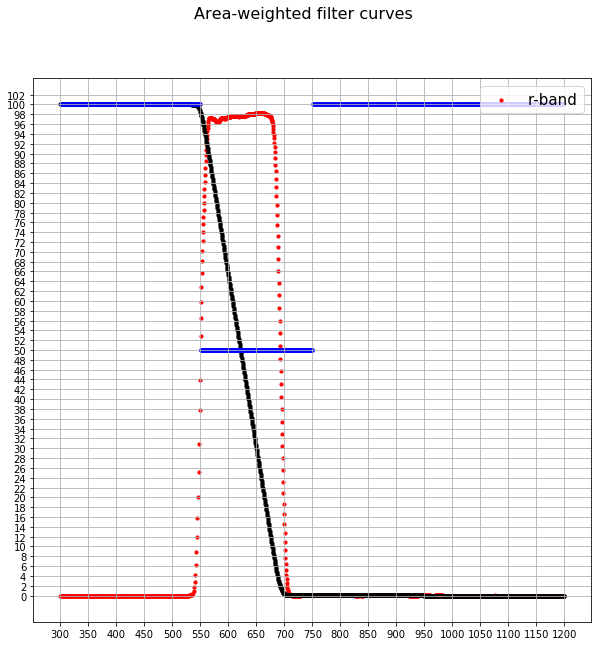

In [2]:
rvalues = np.loadtxt('r-band-areaweighted.txt')
print('There are '+str(len(rvalues))+' data points')
#print(values[1][0])
rx=np.arange(0,len(rvalues),1.)
ry=np.arange(0,len(rvalues),1.)
for i in range(0,len(rvalues)):
    rx[i]=rvalues[i][0]
    ry[i]=rvalues[i][1]
fig1=plt.figure(1,[figwidth,figheight])
fig1.suptitle('Area-weighted filter curves', fontsize=16)
plt.scatter(rx, ry, 10,'r',label='r-band',)
#for i in range(0,len(values)):
#    plt.scatter(values[i][0], values[i][1], 10,'r')
pylab.legend(loc='upper right',prop={'size':15})
ax=fig1.gca()
ax.grid(True)
z=ax.set_xticks(np.arange(300., 1205., 50.))
z=ax.set_yticks(np.arange(0., 104., 2.))
fig1.savefig('filters.pdf')
# let's check some numbers
rinteg=0.*ry
peak=max(ry)
for i in range(0,len(rvalues)-1):
    rinteg[i+1]=rinteg[i]+ry[i]*abs(rx[i+1]-rx[i])
plt.scatter(rx, 100.*rinteg/rinteg[len(rvalues)-1], 10,'black')
#print(rinteg[len(rvalues)-1],peak,max(rx),len(rvalues))
#fig2=plt.figure(2,[figwidth,figheight])
#fig2.suptitle('Look at intervals', fontsize=16)
for i in range(0,len(rvalues)-1):
    plt.scatter(rx[i],100.*(-rx[i+1]+rx[i]) , 10,'b')

In the above plot, the blue is the normalized size of the interval in the data: 100 corresponds to 1nm, 50 corresponds to 0.5nm. Materion provided finer data in the region 550-750nm, apparently.
The black is the running integral from the right.

Let's check compliance with OPT-FILTCOAT-008, which reads: Integrated transmission over wavelength range when transmission first goes below 0.1% of Peak (between 300nm and 1200nm), over the incident cone angle and over each 100mmm aperture shall be < 0.03% total transmission. Out of band transmission can be combined with sensor QE provided in Table 8 for wavelength greater than 1050nm. See Figure 1, Table 3 and Table 6 for details.

In [3]:
# let's look at some numbers
#rrun=list(itertools.accumulate(ry))
# we cannot use accumulate as the data are not of equal bin widths
# use rinteg instead
# first, find the peak, then walk forward and backward 
#to find index when the value first falls below 0.1% 
max_index, max_value = max(enumerate(ry), key=operator.itemgetter(1))
print('here are the max value, peak (should be the same) and the data point index of max:\n',round(max_value,3),round(peak,2),max_index,'\n')
ihi=max_index
while (ry[ihi]>0.001*peak):
    ihi+=1
#print(ihi,ry[ihi],rx[ihi])
ilo=max_index
while (ry[ilo]>0.001*peak):
    ilo+=-1
#print(ilo,ry[ilo],rx[ilo])
# integrated out-of-band
intoutlo=rinteg[ilo]-rinteg[1]
intouthi=rinteg[len(rvalues)-1]-rinteg[ihi]
intout=(rinteg[ilo]-rinteg[1])+(rinteg[len(rvalues)-1]-rinteg[ihi])
print('The integral relevant to requirement OPT-FILTCOAT-008 is ',round(intout,2),'\n')
print('which is',round(100.*intout/rinteg[len(rvalues)-1],2),'% of the total integral (against a 0.03% requirement) \n')
print('which is composed of the longer-wavelenth and shorter-wavelength sides as follows: \n')
print(round(100.*intoutlo/rinteg[len(rvalues)-1],4),'% and ',round(100.*intouthi/rinteg[len(rvalues)-1],4),'%')



here are the max value, peak (should be the same) and the data point index of max:
 98.34 98.34 638 

The integral relevant to requirement OPT-FILTCOAT-008 is  11.36 

which is 0.08 % of the total integral (against a 0.03% requirement) 

which is composed of the longer-wavelenth and shorter-wavelength sides as follows: 

0.0799 % and  0.0019 %


So, we see all the leakage is on the inthoutlo side, meaning longer wavelength. This isn't just because of the wider interval from 711nm to 1200nm. We allow inclusion of QE in Table 8 of LCA-10210 above 1050nm, but that's also not the issue. Let's have a look at the transmission above 711nm next, showing where the transmission first drops below 0.1% of peak:

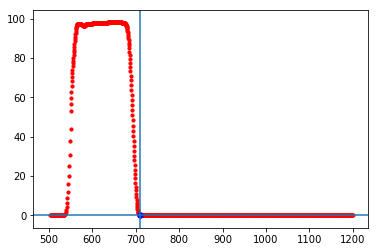

In [4]:
for i in range(0,ilo+370):
    plt.scatter(rx[i],ry[i], 10,'r')
plt.axvline(x=rx[ilo])
plt.axhline(y=ry[ilo])
plt.scatter(rx[ilo],ry[ilo], 30,'b')



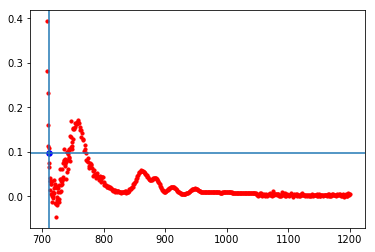

In [5]:
#zooming in:
for i in range(0,ilo+7):
    plt.scatter(rx[i],ry[i], 10,'r')
plt.axvline(x=rx[ilo])
plt.axhline(y=ry[ilo])
plt.scatter(rx[ilo],ry[ilo], 30,'b')




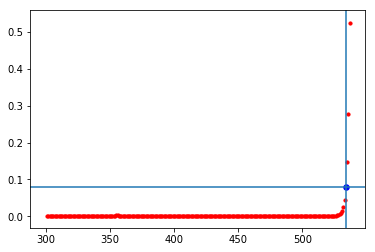

In [6]:
for i in range(ihi-3,len(rvalues)-1):
    plt.scatter(rx[i],ry[i], 10,'r')
plt.axvline(x=rx[ihi])
plt.axhline(y=ry[ihi])
plt.scatter(rx[ihi],ry[ihi], 30,'b')



So the issue is the leakage just outside the band, apparently, and only on the longer-wavelength side.
